1. 10_20151125_noon
2. 11_20151024_night
3. 12_20150928_noon
4. 13_20150929_noon
5. 14_20151014_night
6. 15_20151126_night
7. 16_20151128_night
8. 17_20150925_noon
9. 18_20150926_noon
10. 19_20151114_noon
11. 1_20151124_noon_2
12. 20_20151129_night
13. 21_20151016_noon
14. 2_20151106_noon
15. 3_20151024_noon
16. 4_20151105_noon
17. 4_20151107_noon
18. 5_20141108_noon
19. 5_20151012_night
20. 6_20151121_noon
21. 7_20151015_night
22. 8_20151022_noon
23. 9_20151017_night


C:\Users\janis\AppData\Local\Temp\ipykernel_6880\257744935.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = participant_data.groupby('quantized_perclos')
C:\Users\janis\AppData\Local\Temp\ipykernel_6880\257744935.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


Saved: visualizations\14_20151014_night_band_power_topomap.png


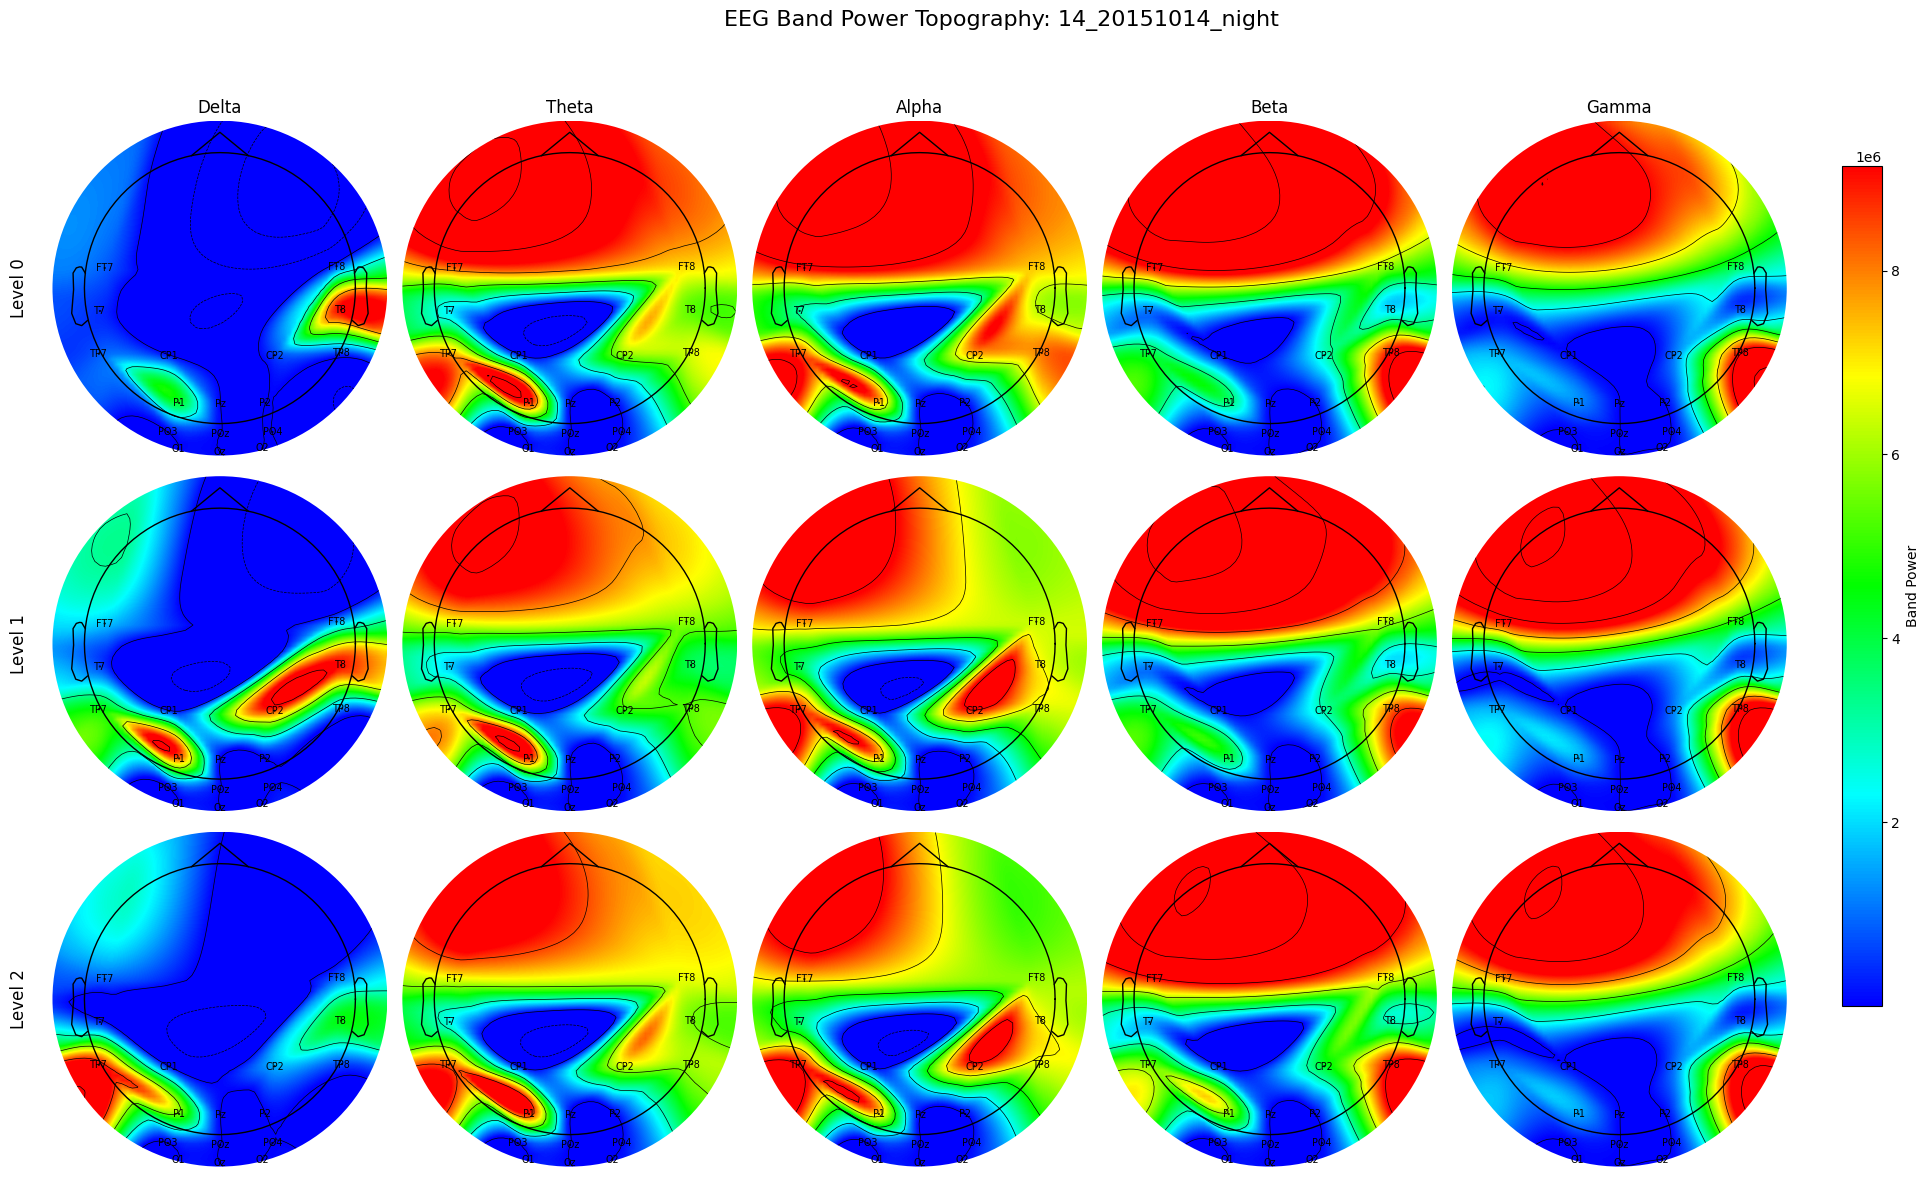

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import mne
from mne.viz import plot_topomap
from utils.data_load import read_participant_names, load_single_user_data

# map channel numbers to uppercase 10-20 labels
channel_mapping = {
    1:  'FT7',  2: 'FT8',  3: 'T7',  4: 'T8',  5: 'TP7',  6: 'TP8',
    7:  'CP1',  8: 'CP2',  9: 'P1', 10: 'Pz', 11: 'P2', 12: 'PO3',
   13: 'POz', 14: 'PO4', 15: 'O1', 16: 'Oz', 17: 'O2'
}

montage = mne.channels.make_standard_montage('standard_1020')
pos_dict = montage.get_positions()['ch_pos']  # name -> (x,y,z)

bands = {'delta': 1, 'theta': 2, 'alpha': 3, 'beta': 4, 'gamma': 5}
band_labels = ['delta', 'theta', 'alpha', 'beta', 'gamma']

colors = [(0,0,1),(0,1,1),(0,1,0),(1,1,0),(1,0,0)]
brain_cmap = LinearSegmentedColormap.from_list('brain_activity', colors)

def plot_eeg_band_power_heatmap(participant_data, title=None, save_path=None):
    grouped = participant_data.groupby('quantized_perclos')
    global_min, global_max = np.inf, -np.inf

    # compute global vmin/vmax
    for level in [0,1,2]:
        if level in grouped.groups:
            df = grouped.get_group(level)
            for band_idx in bands.values():
                vals = [
                    df[f"EEG_5Bands_ch{ch}_feat{band_idx}"].mean()
                    for ch in channel_mapping
                    if f"EEG_5Bands_ch{ch}_feat{band_idx}" in df
                ]
                if vals:
                    global_min = min(global_min, min(vals))
                    global_max = max(global_max, max(vals))
    if not np.isfinite(global_min):
        global_min, global_max = 0, 1

   
    #fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    fig, axes = plt.subplots(3, 5, figsize=(20, 12), subplot_kw={'aspect': 'equal'})

    if title:
        fig.suptitle(title, fontsize=16)

    for lvl_i, level in enumerate([0,1,2]):
        for b_i, band in enumerate(band_labels):
            ax = axes[lvl_i, b_i]
            src, names = [], []
            if level in grouped.groups:
                df = grouped.get_group(level)
                for ch in channel_mapping:
                    col = f"EEG_5Bands_ch{ch}_feat{bands[band]}"
                    if col in df:
                        src.append(df[col].mean())
                        names.append(channel_mapping[ch])
            if src:
                # extract 2D positions
                pos = np.array([pos_dict[n][:2] for n in names])
                plot_topomap(
                    np.array(src),
                    pos,
                    axes=ax,
                    show=False,
                    names=names,
                    cmap=brain_cmap
                    
                )
            ax.axis('off')
            if lvl_i == 0:
                ax.set_title(band.capitalize())
            if b_i == 0:
                ax.text(
                    -0.1, 0.5, f"Level {level}",
                    rotation=90, va="center", ha="center",
                    fontsize=12, transform=ax.transAxes
                )

    # colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(global_min, global_max)
    cb = fig.colorbar(
        plt.cm.ScalarMappable(cmap=brain_cmap, norm=norm),
        cax=cax
    )
    cb.set_label('Band Power')

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    return fig

def visualize_participant_band_power(participant_name, base_dir="SEED-VIG", output_dir="visualizations"):
    os.makedirs(output_dir, exist_ok=True)
    data = load_single_user_data(participant_name, base_dir)
    save_path = os.path.join(output_dir, f"{participant_name}_band_power_topomap.png")
    fig = plot_eeg_band_power_heatmap(
        data,
        title=f"EEG Band Power Topography: {participant_name}",
        save_path=save_path
    )
    print(f"Saved: {save_path}")
    return fig

if __name__ == "__main__":
    base_dir = "SEED-VIG"
    perclos_dir = os.path.join(base_dir, "perclos_labels")
    names = read_participant_names(perclos_dir)["Participant Name"].tolist()
    for idx, name in enumerate(names, start=1):
        print(f"{idx}. {name}")
    try:
        choice = int(input(f"Choose (1–{len(names)}): ")) - 1
        if not (0 <= choice < len(names)):
            choice = 0
    except:
        choice = 0
    visualize_participant_band_power(names[choice], base_dir)
